In [12]:
!pip install pandas

In [4]:
!pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


In [8]:
!pip install numpy

In [ ]:
!pip install matplotlib

In [10]:
!pip install scikit-learn

In [285]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import re
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

data = pd.read_csv("BankChurners.csv")
data = data.drop(["CLIENTNUM"], axis=1)
origin_data = data.copy()
# data["Attrition_Flag"] = data["Attrition_Flag"].map({"Attrited Customer": 0,
#                                                      "Existing Customer": 1})


In [249]:
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.103,1283.51,42,1.069,0.061,0.000093,0.999910
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.103,1291.00,33,1.069,0.105,0.000057,0.999940
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,1.103,1887.00,28,1.069,0.000,0.000042,0.999960
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.103,1283.51,28,1.069,0.760,0.000134,0.999870
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,22,5,...,4716.0,0,4716.0,1.103,1283.51,28,1.069,0.000,0.000042,0.999960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,...,4003.0,1851,2152.0,0.703,14212.00,105,0.857,0.462,0.000191,0.999810
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,...,4277.0,2186,2091.0,0.804,8764.00,69,0.683,0.511,0.995270,0.004729
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,...,5409.0,0,5409.0,0.819,10291.00,60,0.818,0.000,0.996970,0.003025
10125,Attrited Customer,33,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,...,5281.0,0,5281.0,0.535,8395.00,62,0.722,0.000,0.996710,0.003294


In [254]:
def get_unique(x: np.ndarray, y: np.ndarray):
    x_set = np.array([x[0, :], ])
    y_set = np.array([y[0]])
    for i in range(len(x)):
        for j in range(len(x_set)):
            if all(x_set[j, :] == x[i, :]):
                break
        else:
            x_set = np.vstack((x_set, x[i, :]))
            y_set = np.vstack((y_set, y[i]))
    return x_set, y_set

def analyze_data(dataset: pd.core.frame.DataFrame, target_name: str,
                 max_diff: float): # TODO: use another approach of function realizing
    target_data_arr = dataset[target_name].values
    dataset = dataset.drop([target_name], axis=1)
    trash_features = []
    for feature_name in dataset.keys():
        feature_data = dataset[feature_name]
        feature_data_dict = dict() # feature_data_dict =
        # {<feature_i-data>:  {
        #                     "count": <numb of same feature_i-data>,
        #                     "pos_target": <numb of positive target for objects with this feature_i-data>,
        #                     "neg_target": <numb of negative target for objects with this feature_i-data>
        #                     }
        # }

        for idx, feat_i in enumerate(feature_data):
            if feature_data_dict.get(feat_i, None) is None:
                feature_data_dict[feat_i] = {"count": 1, "pos_target": 0, "neg_target": 0}
            else:
                feature_data_dict[feat_i]["count"] += 1

            if target_data_arr[idx] == 0:
                feature_data_dict[feat_i]["neg_target"] += 1
            else:
                feature_data_dict[feat_i]["pos_target"] += 1

        print(f"\n{feature_name} pos/neg target ratio:")
        feature_i_ratio = []
        for i in feature_data_dict.items():
            pos = i[1]['pos_target'] # number of positive target for objects with this feature_i-data
            neg = i[1]['neg_target'] # number of negative target for objects with this feature_i-data
            if (neg == 0 or pos == 0):
                info_str = f"{feature_name} : {i[0]} ,ratio = {pos} / {neg}"
            else:
                info_str = f"{feature_name} : {i[0]} ,ratio = {pos} / {neg} = {round(pos / neg, 3)} " \
                           f"\tpos_perc = {round(100 * pos / (pos + neg), 2)}%, " \
                           f"neg_perc = {round(100 * neg / (pos + neg), 2)}%"
                feature_i_ratio.append(pos / neg)
            print(info_str)
        if (max(feature_i_ratio) - min(feature_i_ratio) < max_diff):
            trash_features.append(feature_name)
    return trash_features1

def identify_data_type(dataset: pd.core.frame.DataFrame):
    features_list = list(dataset.columns)
    features_types_dict = {"Categorical": [], "Numerical": []}
    for feature_name in features_list:
        if any([type_i in data[feature_name].dtype.name
                for type_i in ["int", "object"]]):
            features_types_dict["Categorical"].append(feature_name)
        elif "float" in data[feature_name].dtype.name:
            features_types_dict["Numerical"].append(feature_name)
    return features_types_dict

def get_metrics(targets: np.ndarray, predicted_targets: np.ndarray, mode: str):
    '''

    :param targets:
    :param predicted_targets:
    :param mode: influence to return: mode = "show_metrics" - print metrics to the Console;
                                        mode = "return_metrics" - return dict which consists all metrics values
                                        with their names as keys
    :return:
    {
    "accuracy": accuracy_value, "precision": precision_value,
    "recall": recall_value, "f1_score": f1_score_value,
    "confusion_matrix": confusion_matrix
    }
    '''
    # token = (actual target, predicted target)
    # 1 - positive target, 0 - negative target
    tokens = [(j, i) for i in [1, 0] for j in [1, 0]]
    # tokens = [true_pos_token,
    #           false_pos_token,
    #           false_neg_token,
    #           false_pos_token]
    c = Counter(zip(targets, predicted_targets))
    [true_pos_value,
     false_pos_value,
     false_neg_value,
     true_neg_value] = [c[token] for token in tokens]
    # print(f"true positive value = {true_pos_value}")
    # print(f"false positive value = {false_pos_value}")
    # print(f"false negative value = {false_neg_value}")
    # print(f"true negative value = {true_neg_value}")
    accuracy = (true_neg_value + true_neg_value) / len(targets)
    precision = true_pos_value / (true_pos_value + false_pos_value)
    recall = true_pos_value / (true_pos_value + false_neg_value)
    f1_score = 2 * precision * recall / (precision + recall)
    confusion_matrix = np.array([[true_pos_value, false_neg_value],
                                 [false_pos_value, true_neg_value]])
    if mode == "show_metrics":
        print(f"accuracy = {accuracy}")
        print(f"precision = {precision}")
        print(f"recall = {recall}")
        print(f"f1_score = {f1_score}")
        print(f"confusion_matrix = \n{confusion_matrix}")
    elif mode == "return_metrics":
        res_dict = {"accuracy": accuracy, "precision": precision, "recall": recall,
                    "f1_score": f1_score, "confusion_matrix": confusion_matrix}
        return res_dict

def handle_outliers(feature_data: pd.core.frame.DataFrame, placeholder_val: float,
                    method: str = "statistic_quantiles",
                    method_koef: float = 0.95,
                    placeholder_type: str = "quantile"):
    '''

    :param feature_data:
    :param placeholder_val:
    :param method: available methods: "statistic_quantiles", "elliptic_envelope"
    :param method_koef: coefficient that depends on method
    :param placeholder_type: available placeholder types:
    "own": placeholder_val have to contain value of your own placeholder;
    "quantile": placeholder_val have to contain percent coefficient for quantile,
    that replaces placeholder_val with it's value
    :return: (feature_data, outlier_data), feature_data - feature data with processed outlier values;
    outlier_data - outlier values that was chose by :param method:
    '''
    feature_data = feature_data.copy()
    manage_array :np.array # (10127, 1)
    if method == "statistic_quantiles":
        if method_koef > 0.5:
            manage_array = feature_data > feature_data.quantile(q=method_koef)
        else:
            manage_array = feature_data < feature_data.quantile(q=method_koef)
    elif method == "elliptic_envelope":
        outlier = EllipticEnvelope(contamination=method_koef)
        x = feature_data.values.reshape(-1, 1)
        outlier.fit(x)
        res = outlier.predict(x)
        manage_array = [True if i == -1 else False for i in res]

    outlier_data = feature_data[manage_array]
    # print(len(outlier_data))
    if placeholder_type != "own":
        if placeholder_type == "quantile":
            placeholder_val = feature_data.quantile(placeholder_val)
    feature_data[manage_array] = placeholder_val
    # print(feature_data)
    # print(manage_array)
    return feature_data, outlier_data



accuracy = 0.25
precision = 0.75
recall = 0.5
f1_score = 0.6
confusion_matrix = 
[[3 3]
 [1 1]]


# dataset preparing

In [ ]:
get_metrics(targets=np.array([1,1,1,0,1,0,1,1]),
            predicted_targets=np.array([1,1,0,1,0,0,1,0]),
            mode="show_metrics")

In [31]:
drop_features = [
    "Credit_Limit", "Total_Revolving_Bal",
    "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1",
    "Total_Ct_Chng_Q4_Q1", "Total_Trans_Amt",
    "Avg_Utilization_Ratio",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]

Le = LabelEncoder()
data["Attrition_Flag"] = Le.fit_transform(data["Attrition_Flag"].values)
# can be used only after Attrition_Flag encoding
analyze_data(dataset=data.drop(drop_features, axis=1), target_name="Attrition_Flag",
             max_diff=1.5)


Customer_Age pos/neg target ratio:
Customer_Age : 45 ,ratio = 407 / 79 = 5.152 	pos_perc = 83.74%, neg_perc = 16.26%
Customer_Age : 49 ,ratio = 416 / 79 = 5.266 	pos_perc = 84.04%, neg_perc = 15.96%
Customer_Age : 51 ,ratio = 340 / 58 = 5.862 	pos_perc = 85.43%, neg_perc = 14.57%
Customer_Age : 40 ,ratio = 297 / 64 = 4.641 	pos_perc = 82.27%, neg_perc = 17.73%
Customer_Age : 44 ,ratio = 416 / 84 = 4.952 	pos_perc = 83.2%, neg_perc = 16.8%
Customer_Age : 32 ,ratio = 89 / 17 = 5.235 	pos_perc = 83.96%, neg_perc = 16.04%
Customer_Age : 37 ,ratio = 223 / 37 = 6.027 	pos_perc = 85.77%, neg_perc = 14.23%
Customer_Age : 48 ,ratio = 387 / 85 = 4.553 	pos_perc = 81.99%, neg_perc = 18.01%
Customer_Age : 42 ,ratio = 364 / 62 = 5.871 	pos_perc = 85.45%, neg_perc = 14.55%
Customer_Age : 65 ,ratio = 92 / 9 = 10.222 	pos_perc = 91.09%, neg_perc = 8.91%
Customer_Age : 56 ,ratio = 219 / 43 = 5.093 	pos_perc = 83.59%, neg_perc = 16.41%
Customer_Age : 35 ,ratio = 163 / 21 = 7.762 	pos_perc = 88.59%, neg

['Gender', 'Dependent_count', 'Marital_Status']

# data type identifying

In [3]:
features_types = identify_data_type(dataset=data)
numerical_features = features_types["Numerical"]

numerical_features += ["Total_Trans_Ct", "Total_Revolving_Bal",
                       "Total_Trans_Amt", "Customer_Age", "Months_on_book"]
features_types["Categorical"].remove("Customer_Age")
features_types["Categorical"].remove("Total_Trans_Ct")
features_types["Categorical"].remove("Total_Revolving_Bal")
features_types["Categorical"].remove("Total_Trans_Amt")
features_types["Categorical"].remove("Months_on_book")

ordinal_features = ["Dependent_count", "Education_Level", "Card_Category",
                "Income_Category", "Total_Relationship_Count",
                "Months_Inactive_12_mon", "Contacts_Count_12_mon"]
categorical_features = [i for i in features_types["Categorical"] if i not in ordinal_features]
# data[features_types["Categorical"]]


In [71]:
categorical_features

['Attrition_Flag', 'Gender', 'Marital_Status', 'Card_Category']

In [64]:
# data1 = data[ordinal_features[2: 4]]
# list(zip(Le.fit_transform(data1["Education_Level"].values), data1["Education_Level"].values))
# data1["Education_Level"].unique()
data["Total_Trans_Ct"]

0         42
1         33
2         20
3         20
4         28
        ... 
10122    117
10123     69
10124     60
10125     62
10126     61
Name: Total_Trans_Ct, Length: 10127, dtype: int64

# feature visualizing

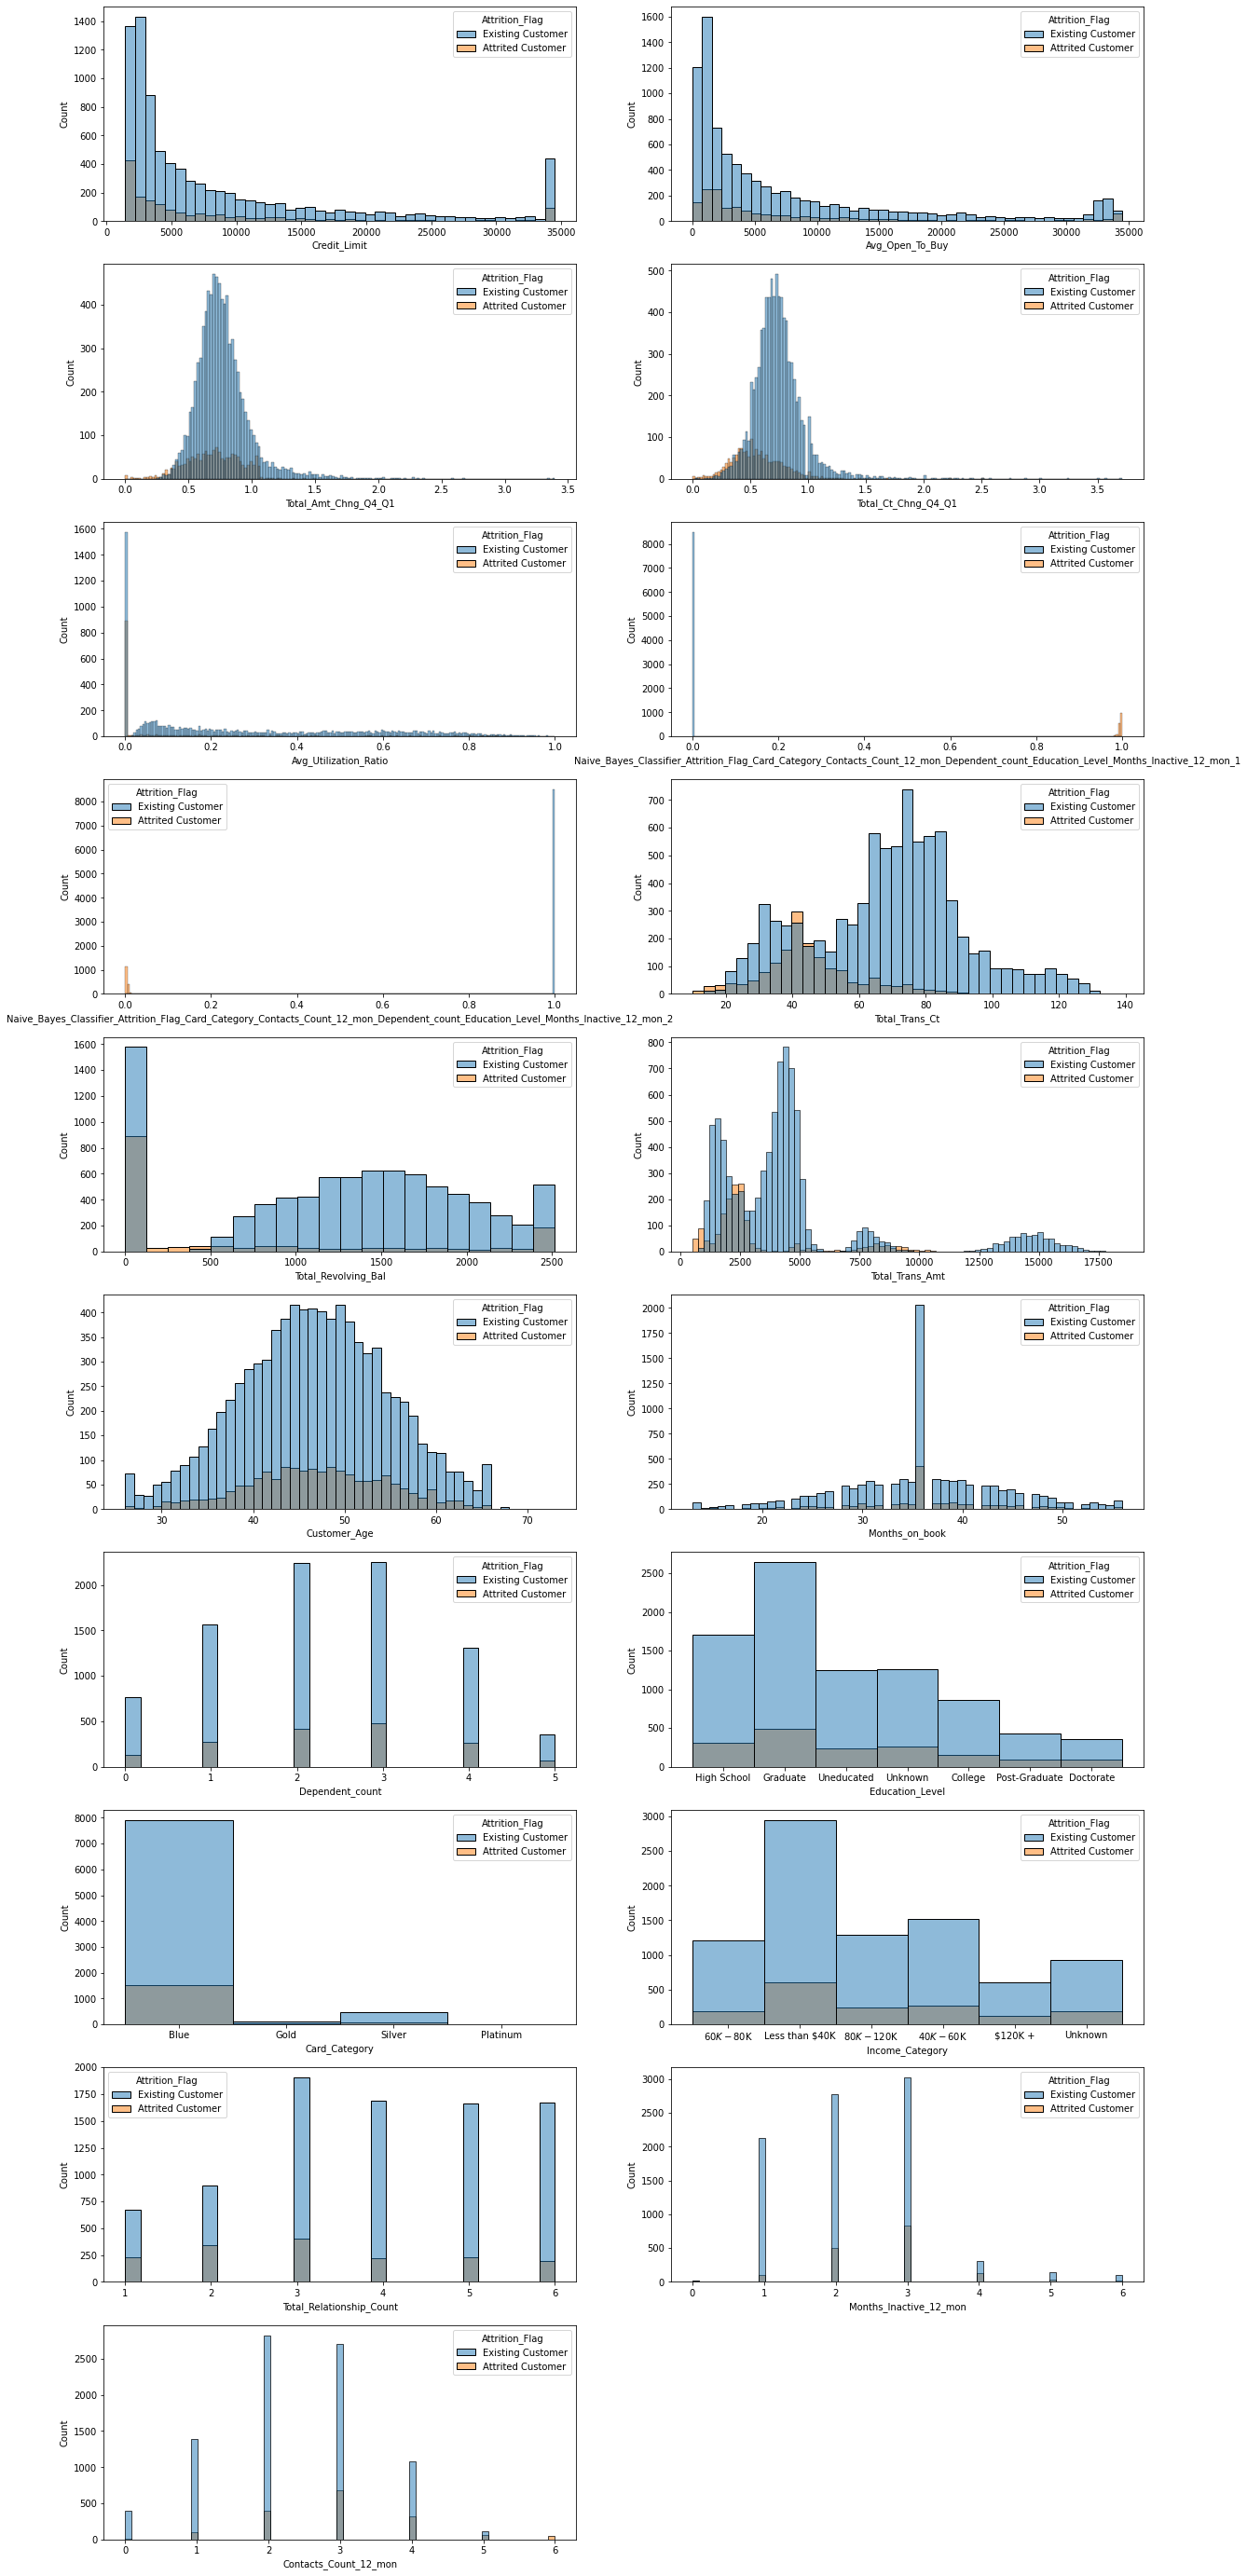

In [75]:
user_binwidth = None
plt.figure(figsize=((20, 50)))
figures_numb_in_row = 2
hist_vizual_data = data[[*numerical_features,
                         *ordinal_features]]
for idx, feature in enumerate(hist_vizual_data):
    if(idx < 21):
        if re.search(f"^{feature[:7]}", "\n".join(["Avg_Uti", "Naive_Ba"]), re.MULTILINE):
            user_binwidth = 0.005
        plt.subplot(hist_vizual_data.shape[1] // figures_numb_in_row + (0 if(hist_vizual_data.shape[1] % figures_numb_in_row == 0) else 1),
                    figures_numb_in_row, idx + 1)
        sns.histplot(x=feature,
                     data=data[[feature, "Attrition_Flag"] if feature != "Attrition_Flag" else [feature]],
                     color=["blue", "green"], hue="Attrition_Flag", binwidth=user_binwidth)
        user_binwidth = None


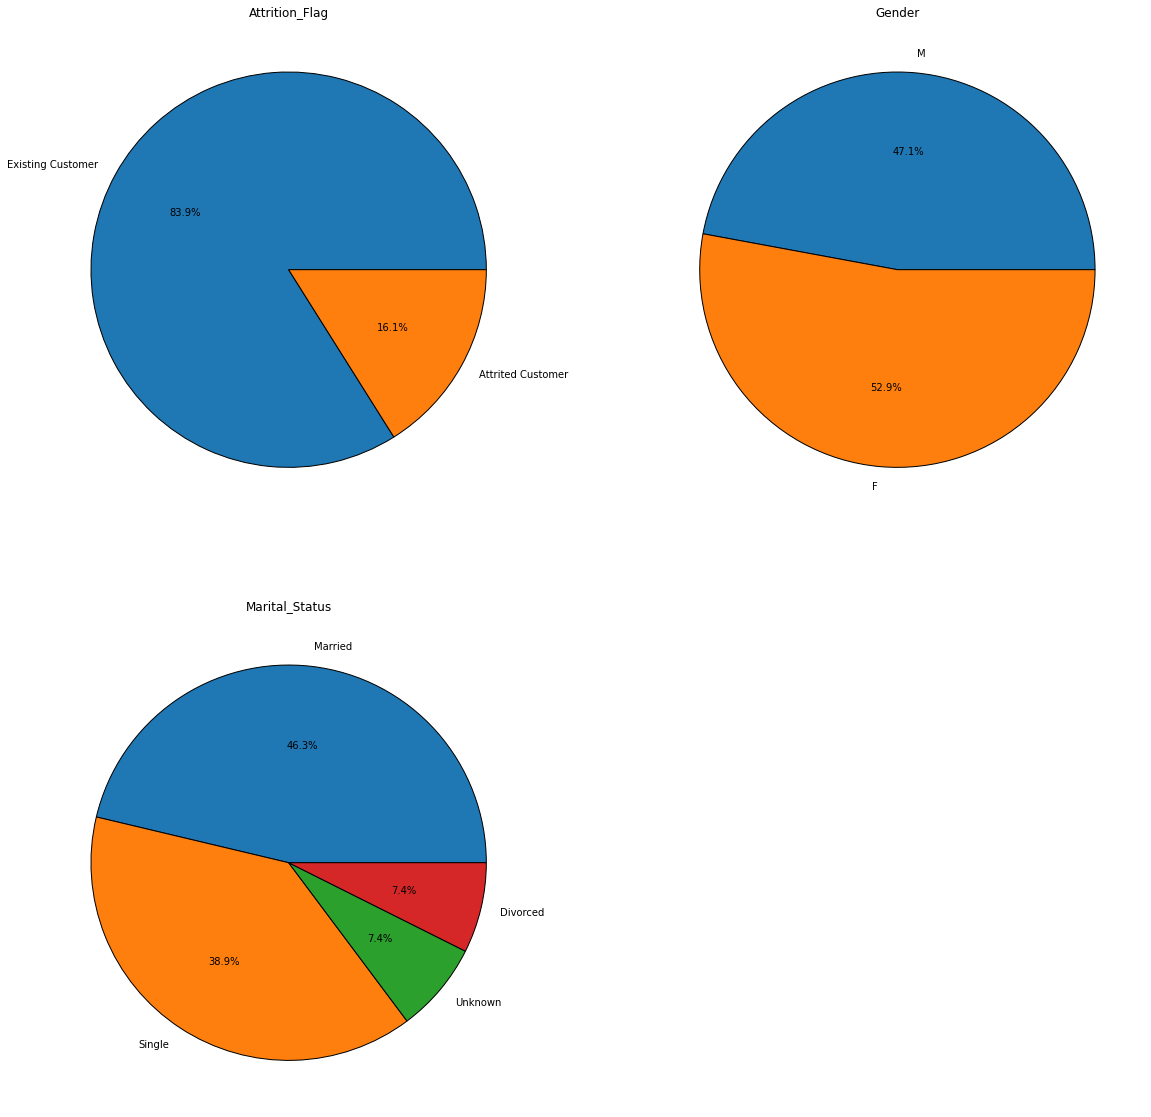

In [76]:
plt.figure(figsize=((20, 20)))

figures_numb_in_row = 2
pie_vizual_data = data[categorical_features]
for idx, feature in enumerate(pie_vizual_data):
    if 1:
        plt.subplot(pie_vizual_data.shape[1] // figures_numb_in_row + (0 if(pie_vizual_data.shape[1] % figures_numb_in_row == 0) else 1),
                    figures_numb_in_row, idx + 1)
        c = Counter(pie_vizual_data[feature])
        plt.title(feature)
        plt.pie(c.values(), labels=c.keys(), wedgeprops={"edgecolor": "black"}, autopct='%1.1f%%')

# END of feature visualizing

([<matplotlib.patches.Wedge at 0x149948d4940>,
 [Text(0.10035590564411727, 1.0954125671190509, 'M'),
  Text(-0.10035590564411717, -1.0954125671190509, 'F')])

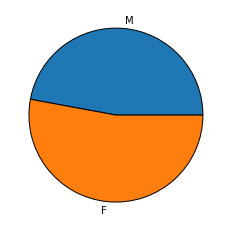

# feature's statistic

In [94]:
data1 = data
education_level_map = {"Unknown": 0,"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4,
                       "Post-Graduate": 5, "Doctorate": 6}
income_category_map = {'$60K - $80K': 3, 'Less than $40K': 1, '$80K - $120K': 4, '$40K - $60K': 2,
                       '$120K +': 5, 'Unknown': 0}
# education level encoding
data1["Education_Level"] = data1["Education_Level"].map(education_level_map)
# income category encoding
data1["Income_Category"] = data1["Income_Category"].map(income_category_map)

mean value of Customer_Age = 46.32596030413745
mean value of Dependent_count = 2.3462032191172115
mean value of Education_Level = 2.601955169349264
mean value of Income_Category = 2.0857114644020935
mean value of Months_on_book = 35.928409203120374
mean value of Total_Relationship_Count = 3.8125802310654686
mean value of Months_Inactive_12_mon = 2.3411671768539546
mean value of Contacts_Count_12_mon = 2.4553174681544387
mean value of Total_Revolving_Bal = 1162.8140614199665
mean value of Total_Trans_Amt = 4404.086303939963
mean value of Total_Trans_Ct = 64.85869457884863
mean value of Credit_Limit = 8631.953698034955
mean value of Avg_Open_To_Buy = 7469.139636614989
mean value of Total_Amt_Chng_Q4_Q1 = 0.759940653698035
mean value of Total_Ct_Chng_Q4_Q1 = 0.7122223758269972
mean value of Avg_Utilization_Ratio = 0.2748935518909845
mean value of Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 = 0.159997463

# mean, standard_deviation

In [98]:
for stat_i in ["mean", "standard_deviation"]:
    for feature in data1[[*ordinal_features, *numerical_features]]:
        if stat_i == 'mean':
            print(f"mean value of {feature} = {data1[feature].mean()}")
        elif stat_i == "standard_deviation":
            print(f"standard_deviation value of {feature} = {data1[feature].std()}")

mean value of Customer_Age = 46.32596030413745
mean value of Dependent_count = 2.3462032191172115
mean value of Education_Level = 2.601955169349264
mean value of Income_Category = 2.0857114644020935
mean value of Months_on_book = 35.928409203120374
mean value of Total_Relationship_Count = 3.8125802310654686
mean value of Months_Inactive_12_mon = 2.3411671768539546
mean value of Contacts_Count_12_mon = 2.4553174681544387
mean value of Total_Revolving_Bal = 1162.8140614199665
mean value of Total_Trans_Amt = 4404.086303939963
mean value of Total_Trans_Ct = 64.85869457884863
mean value of Credit_Limit = 8631.953698034955
mean value of Avg_Open_To_Buy = 7469.139636614989
mean value of Total_Amt_Chng_Q4_Q1 = 0.759940653698035
mean value of Total_Ct_Chng_Q4_Q1 = 0.7122223758269972
mean value of Avg_Utilization_Ratio = 0.2748935518909845
mean value of Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 = 0.159997463

['Credit_Limit',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
 'Total_Trans_Ct',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Customer_Age']

# correlation matrix

In [68]:
data1[[*ordinal_features, *numerical_features]].corr()

['Credit_Limit',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
 'Total_Trans_Ct',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Customer_Age']

# frequency

In [77]:
print("frequency_dict - {<feature_value>: <number of feature_value occurrences>}")
for feature in data[[*categorical_features, *ordinal_features]]:
    print(f"{feature} frequency_dict : \n{dict(data[feature].value_counts())}")

frequency_dict - {<feature_value>: <number of feature_value occurrences>}
Attrition_Flag frequency_dict : 
{'Existing Customer': 8500, 'Attrited Customer': 1627}
Gender frequency_dict : 
{'F': 5358, 'M': 4769}
Marital_Status frequency_dict : 
{'Married': 4687, 'Single': 3943, 'Unknown': 749, 'Divorced': 748}
Dependent_count frequency_dict : 
{3: 2732, 2: 2655, 1: 1838, 4: 1574, 0: 904, 5: 424}
Education_Level frequency_dict : 
{'Graduate': 3128, 'High School': 2013, 'Unknown': 1519, 'Uneducated': 1487, 'College': 1013, 'Post-Graduate': 516, 'Doctorate': 451}
Card_Category frequency_dict : 
{'Blue': 9436, 'Silver': 555, 'Gold': 116, 'Platinum': 20}
Income_Category frequency_dict : 
{'Less than $40K': 3561, '$40K - $60K': 1790, '$80K - $120K': 1535, '$60K - $80K': 1402, 'Unknown': 1112, '$120K +': 727}
Total_Relationship_Count frequency_dict : 
{3: 2305, 4: 1912, 5: 1891, 6: 1866, 2: 1243, 1: 910}
Months_Inactive_12_mon frequency_dict : 
{3: 3846, 2: 3282, 1: 2233, 4: 435, 5: 178, 6: 124

In [25]:
list(enumerate(zip(numerical_features, [1750, 1750, 500 , 500,2500, 10, 10, 700, 2000,700, 400])))
# data[numerical_features[5]]

[(0, ('Credit_Limit', 1750)),
 (1, ('Avg_Open_To_Buy', 1750)),
 (2, ('Total_Amt_Chng_Q4_Q1', 500)),
 (3, ('Total_Ct_Chng_Q4_Q1', 500)),
 (4, ('Avg_Utilization_Ratio', 2500)),
 (5,
  ('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
   10)),
 (6,
  ('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
   10)),
 (7, ('Total_Trans_Ct', 700)),
 (8, ('Total_Revolving_Bal', 2000)),
 (9, ('Total_Trans_Amt', 700)),
 (10, ('Customer_Age', 400))]

In [202]:
data["Marital_Status"]

0         Married
1          Single
2         Married
3         Unknown
4         Married
           ...   
10122      Single
10123    Divorced
10124     Married
10125     Unknown
10126     Married
Name: Marital_Status, Length: 10127, dtype: object

# check the correspondence of plots and statistical values

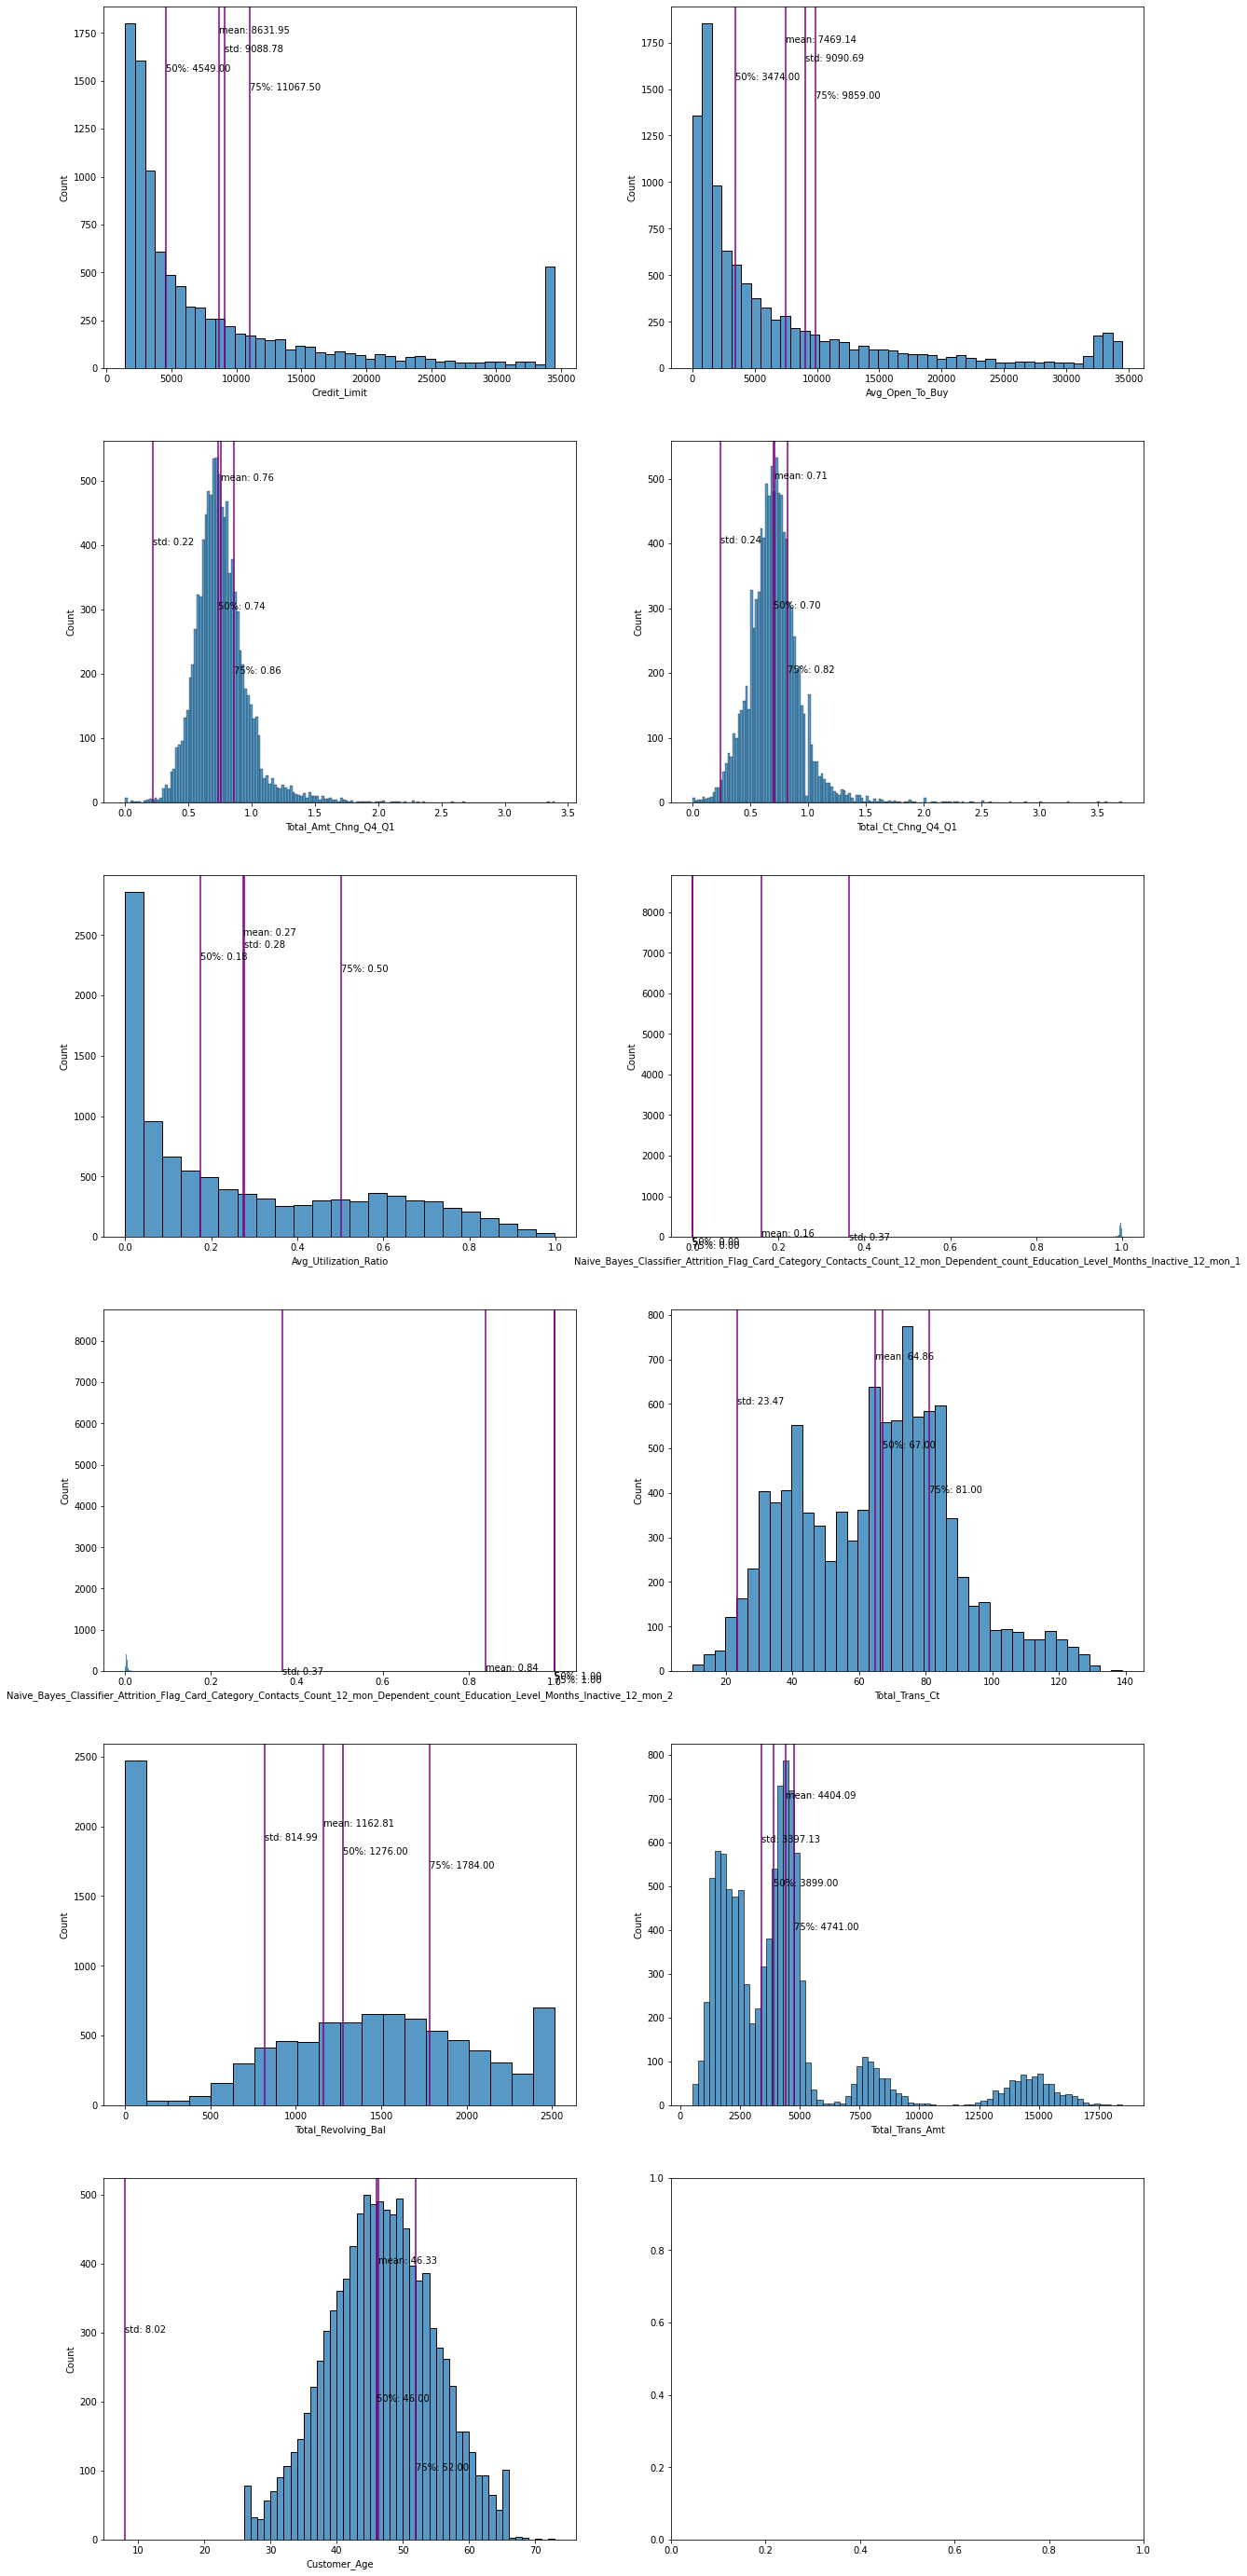

In [70]:
user_binwidth = None

fig, axes = plt.subplots((len(numerical_features) // 2) + 1, 2, figsize=(20, 50))
axes=[j for plot_block in axes for j in plot_block]
for feat_idx, feature_plot_element in enumerate(zip(numerical_features, [1750, 1750, 500 , 500,
                                                                         2500, 10, 10, 700, 2000,
                                                                         700, 400])):
    if 1:
        if "Naive_Bayes_Classifier_" in feature_plot_element[0]:
            user_binwidth = 0.001
        statistic_labels = ["mean", "std", "50%", "75%"]
        statistic_data = data[feature_plot_element[0]].describe()
        statistic_values = [statistic_data[i] for i in statistic_labels]
        sns.histplot(x=data[feature_plot_element[0]], stat="count", ax=axes[feat_idx],
                     binwidth=user_binwidth)
        user_binwidth = None
        for idx, stat_val in enumerate(statistic_values):
            axes[feat_idx].axvline(stat_val, color="purple")
            axes[feat_idx].text(x=stat_val, y=(feature_plot_element[1] - idx * 100),
                                s="{}: {:.2f}".format(statistic_labels[idx],
                                                      stat_val))

# END of feature's statistic

# dataset pre-processing

In [273]:
#return origin numeric features
data[numerical_features] = origin_data[numerical_features]

outliers handling

In [286]:
# x = data[numerical_features[1]].values.reshape(-1, 1)
#
# outlier = EllipticEnvelope(contamination=0.1)
# outlier.fit(x)
# res = outlier.predict(x)
#
# a=[False if i != -1 else True for idx, i in enumerate(res)]
# data[numerical_features[1]][a] = 1
for feature in numerical_features:
    data[feature], out = handle_outliers(feature_data=data[feature],
                                         method="statistic_quantiles", method_koef=0.95,
                                         placeholder_type="quantile", placeholder_val=0.95)
    # print("out len",len(out.keys()))
    # data = data.drop(out.keys(),axis=0)
    data[feature], out = handle_outliers(feature_data=data[feature],
                                         method="statistic_quantiles", method_koef=0.05,
                                         placeholder_type="quantile", placeholder_val=0.05)
    # print("out len",len(out.keys()))
    # data = data.drop(out.keys(),axis=0)


In [288]:
data[numerical_features[-1]][out.keys()]

4        22
67       22
514      22
521      22
560      22
         ..
10062    22
10069    22
10082    22
10112    22
10114    22
Name: Months_on_book, Length: 466, dtype: int64

# box plots for numerical features

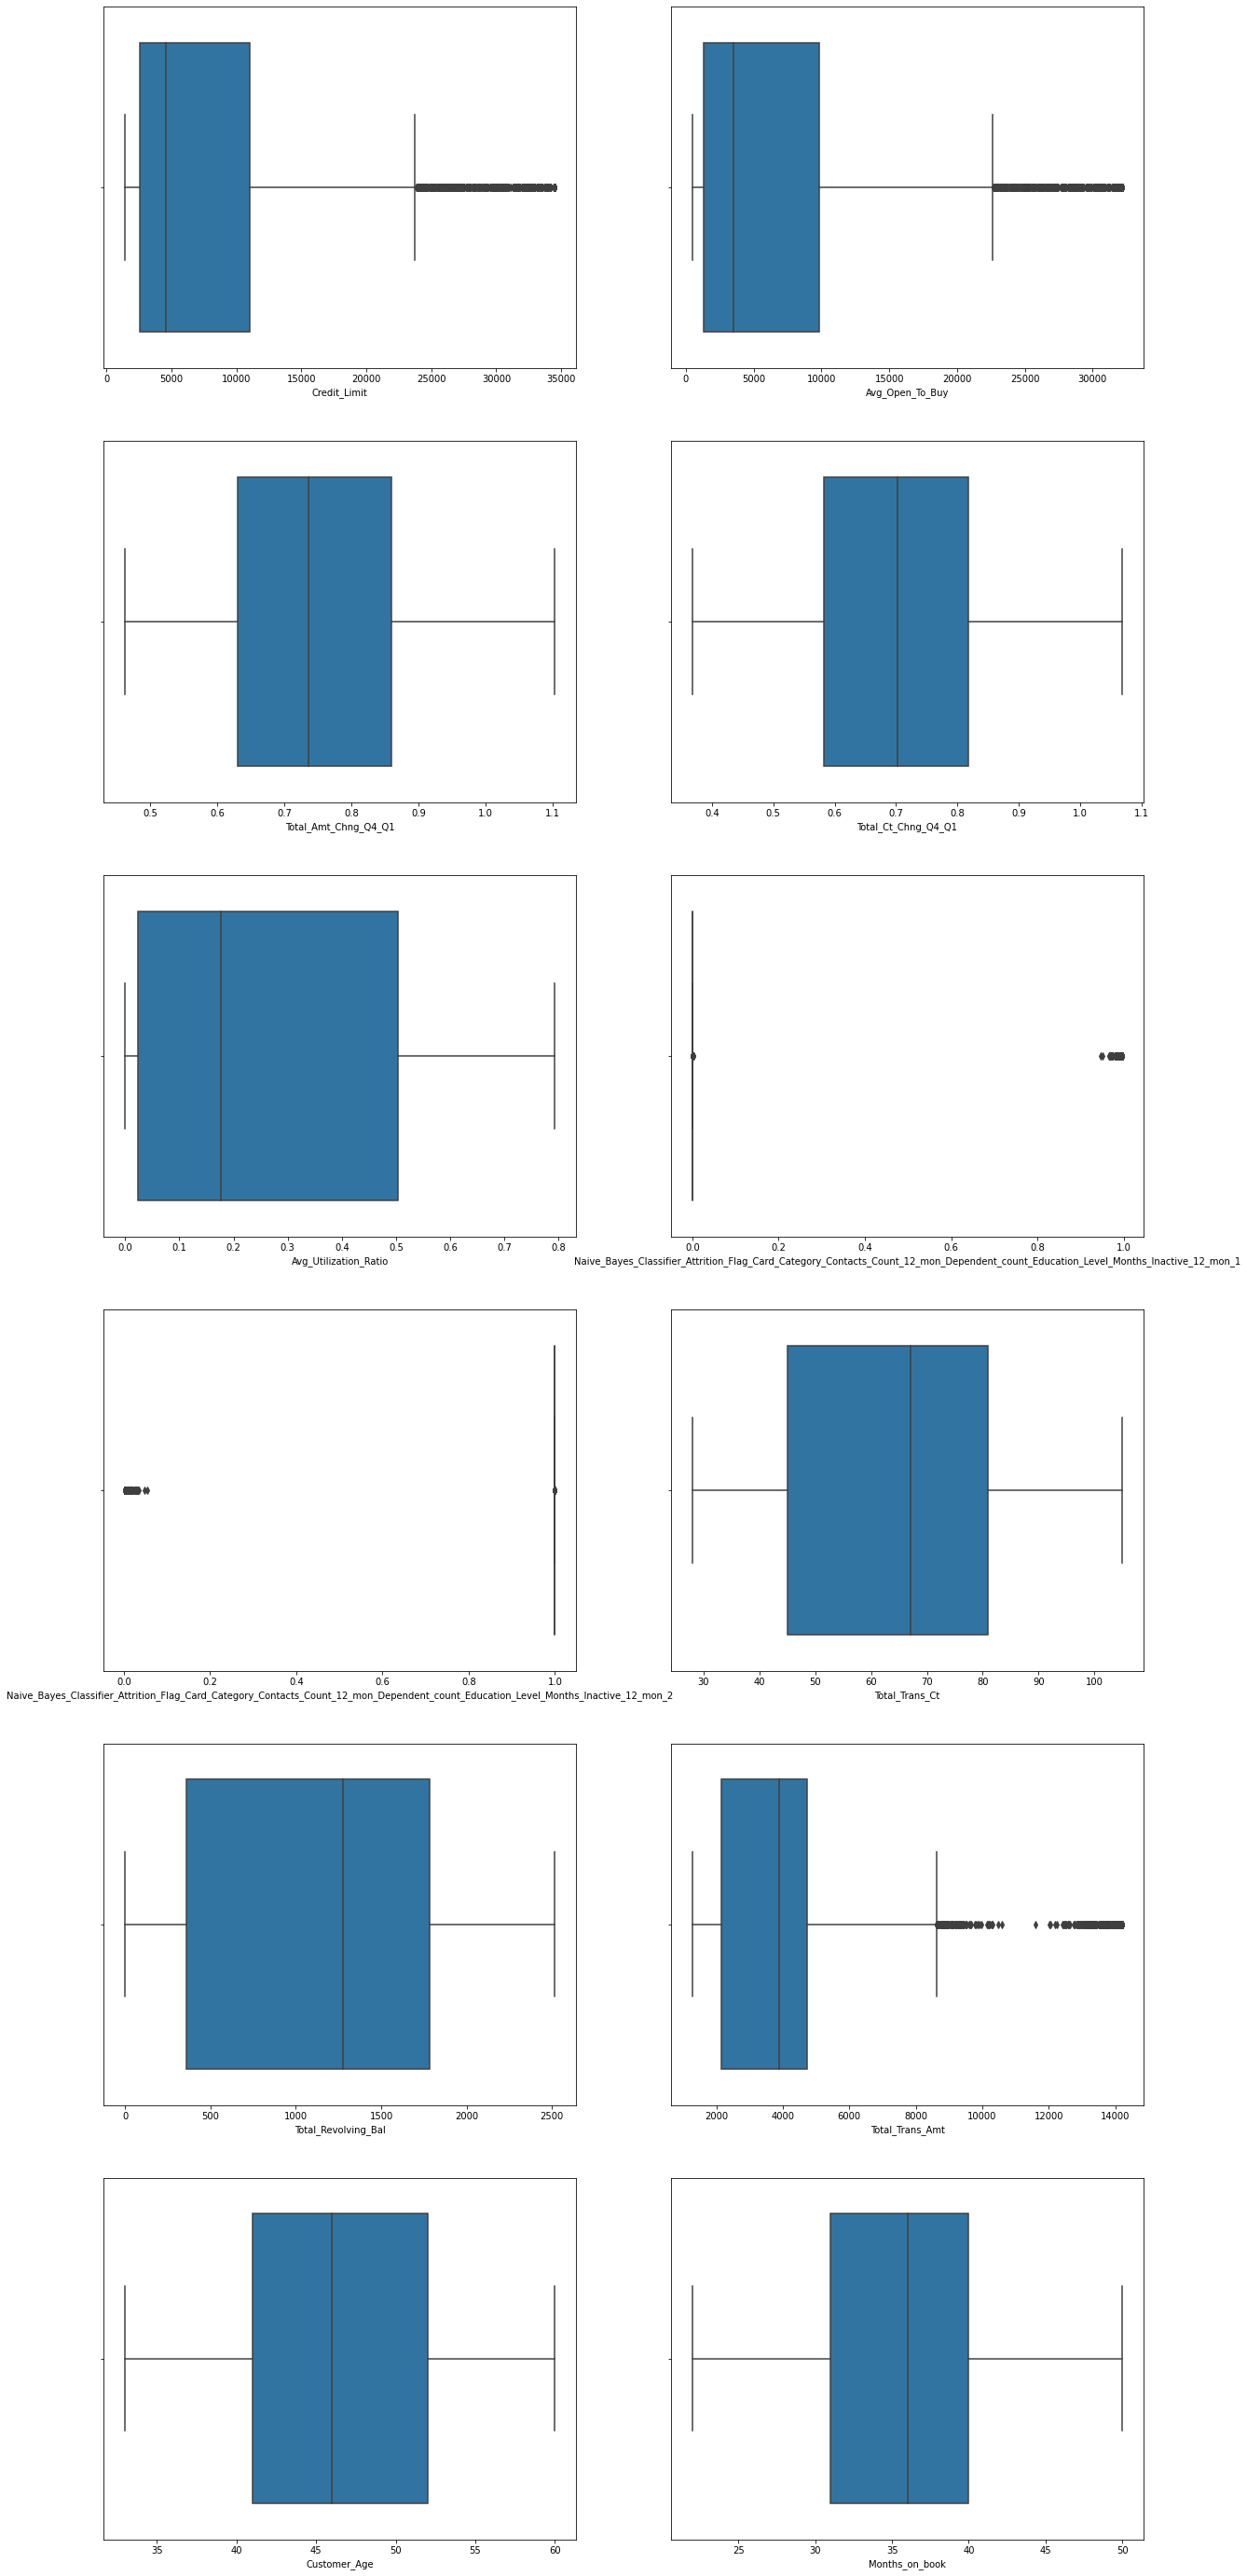

In [289]:
fig, axes = plt.subplots(6, 2, figsize=(20,50))
axes = [graph for line in axes for graph in line]
for idx, feature in enumerate(data[numerical_features]):
    sns.boxplot(x=data[feature], ax=axes[idx])

In [290]:
data


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.103,1283.3,42,1.069,0.061,0.000093,0.999910
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.103,1291.0,33,1.069,0.105,0.000057,0.999940
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,1.103,1887.0,28,1.069,0.000,0.000042,0.999960
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.103,1283.3,28,1.069,0.760,0.000134,0.999870
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,22,5,...,4716.0,0,4716.0,1.103,1283.3,28,1.069,0.000,0.000042,0.999960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,...,4003.0,1851,2152.0,0.703,14212.0,105,0.857,0.462,0.000191,0.999810
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,...,4277.0,2186,2091.0,0.804,8764.0,69,0.683,0.511,0.995270,0.004729
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,...,5409.0,0,5409.0,0.819,10291.0,60,0.818,0.000,0.996970,0.003025
10125,Attrited Customer,33,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,...,5281.0,0,5281.0,0.535,8395.0,62,0.722,0.000,0.996710,0.003294


# non-numeric -> numeric

In [291]:
print("Attrition_Flag\n")
Le = LabelEncoder()
data["Attrition_Flag"] = Le.fit_transform(data["Attrition_Flag"].values)
data["Attrition_Flag"]

print("Gender\n")
Le = LabelEncoder()
data["Gender"] = Le.fit_transform(data["Gender"].values)
data["Gender"]

print("Marital_Status\n")
# data["Marital_Status"][data["Marital_Status"] == "Unknown"] = float("nan")

# modified_marital_status = pd.get_dummies(data["Marital_Status"],
#                                          prefix="Marital_Status").drop("Marital_Status_Unknown", axis=1)
# modified_marital_status.iloc[(modified_marital_status.sum(axis=1) == 0).values, :] = float("nan")
# data = data.drop("Marital_Status", axis=1)
# data = pd.concat([data, modified_marital_status], axis=1)

marital_status_map = {'Married': 2, 'Single': 1, 'Divorced': 3}
data["Marital_Status"] = data["Marital_Status"].map(marital_status_map)

print("Income_Category\n")
mean_bin_length = (20 + 20 + 40) / 3
Income_Category_map = {'$60K - $80K': (60 + 80) / 2,
                       'Less than $40K': ((40 - mean_bin_length) + 40) / 2,
                       '$80K - $120K': (80 + 120) / 2, '$40K - $60K':(40 + 60) / 2,
                       '$120K +': (120 + (120 + mean_bin_length)) / 2}
data.Income_Category = data.Income_Category.map(Income_Category_map)

print("Education_Level\n")
education_level_map = {"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4,
                       "Post-Graduate": 5, "Doctorate": 6}
data.Education_Level = data["Education_Level"].map(education_level_map)

print("Card_Category\n")
card_category_map = {"Blue": 1, "Gold": 2, "Silver": 3, "Platinum": 4}
data.Card_Category = data["Card_Category"].map(card_category_map)


Attrition_Flag

Gender

Marital_Status

Income_Category

Education_Level

Card_Category



0        1
1        0
2        1
3        0
4        1
        ..
10122    1
10123    1
10124    0
10125    1
10126    0
Name: Gender, Length: 10127, dtype: int32

Marital_Status

In [131]:
# data["Marital_Status"][data["Marital_Status"] == "Unknown"] = float("nan")

# modified_marital_status = pd.get_dummies(data["Marital_Status"],
#                                          prefix="Marital_Status").drop("Marital_Status_Unknown", axis=1)
# modified_marital_status.iloc[(modified_marital_status.sum(axis=1) == 0).values, :] = float("nan")
# data = data.drop("Marital_Status", axis=1)
# data = pd.concat([data, modified_marital_status], axis=1)

marital_status_map = {'Married': 2, 'Single': 1, 'Divorced': 3}
data["Marital_Status"] = data["Marital_Status"].map(marital_status_map)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,High School,2.0,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,Existing Customer,49,F,5,Graduate,1.0,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,Existing Customer,51,M,3,Graduate,2.0,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,Existing Customer,40,M,3,Uneducated,2.0,$60K - $80K,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,1.0,$40K - $60K,Blue,40,3,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,Attrited Customer,41,M,2,Unknown,3.0,$40K - $60K,Blue,25,4,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,Attrited Customer,44,F,1,High School,2.0,Less than $40K,Blue,36,5,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,Attrited Customer,30,M,2,Graduate,NaN,$40K - $60K,Blue,36,4,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


In [292]:
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,1,45,1,3,2.0,2.0,70.000000,1,39,5,...,12691.0,777,11914.0,1.103,1283.3,42,1.069,0.061,0.000093,0.999910
1,1,49,0,5,4.0,1.0,26.666667,1,44,6,...,8256.0,864,7392.0,1.103,1291.0,33,1.069,0.105,0.000057,0.999940
2,1,51,1,3,4.0,2.0,100.000000,1,36,4,...,3418.0,0,3418.0,1.103,1887.0,28,1.069,0.000,0.000042,0.999960
3,1,40,0,4,2.0,NaN,26.666667,1,34,3,...,3313.0,2517,796.0,1.103,1283.3,28,1.069,0.760,0.000134,0.999870
4,1,40,1,3,1.0,2.0,70.000000,1,22,5,...,4716.0,0,4716.0,1.103,1283.3,28,1.069,0.000,0.000042,0.999960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,1,50,1,2,4.0,1.0,50.000000,1,40,3,...,4003.0,1851,2152.0,0.703,14212.0,105,0.857,0.462,0.000191,0.999810
10123,0,41,1,2,NaN,3.0,50.000000,1,25,4,...,4277.0,2186,2091.0,0.804,8764.0,69,0.683,0.511,0.995270,0.004729
10124,0,44,0,1,2.0,2.0,26.666667,1,36,5,...,5409.0,0,5409.0,0.819,10291.0,60,0.818,0.000,0.996970,0.003025
10125,0,33,1,2,4.0,NaN,50.000000,1,36,4,...,5281.0,0,5281.0,0.535,8395.0,62,0.722,0.000,0.996710,0.003294


Income_Category


In [150]:
mean_bin_length = (20 + 20 + 40) / 3
Income_Category_map = {'$60K - $80K': (60 + 80) / 2,
                       'Less than $40K': ((40 - mean_bin_length) + 40) / 2,
                       '$80K - $120K': (80 + 120) / 2, '$40K - $60K':(40 + 60) / 2,
                       '$120K +': (120 + (120 + mean_bin_length)) / 2}
data.Income_Category = data.Income_Category.map(Income_Category_map)

In [281]:
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
77,1,37,0,3,1.0,1.0,26.666667,1,29,4,...,7038.0,1801.0,5237.0,0.751,2339.0,57,0.966,0.256,0.000232,0.99977
97,1,53,1,3,6.0,2.0,50.000000,1,35,5,...,3789.0,1706.0,2083.0,1.047,1609.0,42,0.680,0.450,0.000270,0.99973
192,1,57,0,3,4.0,2.0,26.666667,1,47,4,...,6347.0,1594.0,4753.0,0.896,1771.0,37,0.762,0.251,0.000199,0.99980
193,1,54,1,3,6.0,2.0,133.333333,1,41,3,...,21592.0,1676.0,19916.0,1.097,1873.0,52,0.529,0.078,0.000100,0.99990
200,1,48,1,4,NaN,2.0,100.000000,1,36,5,...,5288.0,866.0,4422.0,0.869,1777.0,42,0.750,0.164,0.000076,0.99992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9777,0,43,0,3,6.0,1.0,26.666667,1,30,1,...,6261.0,463.0,5798.0,0.889,8132.0,64,0.600,0.074,0.994180,0.00582
9943,0,52,1,2,3.0,1.0,133.333333,1,32,4,...,4935.0,0.0,4935.0,0.713,7886.0,64,0.882,0.000,0.990610,0.00939
9946,0,44,1,1,1.0,2.0,50.000000,1,34,5,...,10973.0,0.0,10973.0,0.792,10583.0,75,0.786,0.000,0.994620,0.00538
10064,0,43,0,4,2.0,NaN,26.666667,3,31,6,...,13651.0,0.0,13651.0,1.046,9772.0,71,0.775,0.000,0.990550,0.00945


Education_Level

In [139]:
education_level_map = {"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4,
                       "Post-Graduate": 5, "Doctorate": 6}
data.Education_Level = data["Education_Level"].map(education_level_map)

In [56]:
data[data.Education_Level.isnull()]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single


Card_Category

In [134]:
card_category_map = {"Blue": 1, "Gold": 2, "Silver": 3, "Platinum": 4}
data.Card_Category = data["Card_Category"].map(card_category_map)
data[data.Card_Category == 1]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,2.0,2.0,70.000000,1,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,Existing Customer,49,F,5,4.0,1.0,26.666667,1,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,Existing Customer,51,M,3,4.0,2.0,100.000000,1,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,Existing Customer,40,F,4,2.0,NaN,26.666667,1,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,Existing Customer,40,M,3,1.0,2.0,70.000000,1,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10121,Existing Customer,56,F,1,4.0,1.0,26.666667,1,50,4,...,3688.0,606,3082.0,0.570,14596,120,0.791,0.164,0.000148,0.999850
10122,Existing Customer,50,M,2,4.0,1.0,50.000000,1,40,3,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,Attrited Customer,41,M,2,NaN,3.0,50.000000,1,25,4,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,Attrited Customer,44,F,1,2.0,2.0,26.666667,1,36,5,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118


# END of non-numeric -> numeric

predicting missing values using Classification methods

In [293]:
# data1 = data.copy()
# data1 = data1.dropna()
# data1
models = dict()
features_with_missing_values = ["Education_Level", "Income_Category", "Marital_Status"]
for target_feature in features_with_missing_values:
    if target_feature == "Income_Category":
        model = LinearRegression()
    # model = GaussianNB()
    else:
        model = DecisionTreeClassifier(max_depth=8)
    target_columns = [i for i in data if i.startswith(target_feature)]
    train_data_x = data.dropna(axis=0).drop(target_columns, axis=1).values
    # print(f"target_columns: {target_columns}")
    train_data_y = data.dropna(axis=0)[target_columns].values
    # print("x:", train_data_x)
    # print("y:", train_data_y)
    print(f"{target_feature} missing values prediction accuracy: ", cross_val_score(estimator=model, X=train_data_x, y=train_data_y, cv=7).mean())
    model.fit(X=train_data_x, y=train_data_y)
    models[target_feature] = model

# print(models)
for target_feature in features_with_missing_values:
    data_without_target = data.drop([target_feature], axis=1)
    rows_available_to_predict = np.array([not data_without_target.isnull().iloc[i, :].any()
                                 for i in range(data.shape[0])])
    rows_needed_to_predict = np.array(data[target_feature].isnull())
    rows_to_predict = rows_available_to_predict & rows_needed_to_predict

    predicted_target_values = models[target_feature].predict(data_without_target[rows_to_predict].values)
    #crutches
    if target_feature == "Income_Category":
        predicted_target_values = [i[0] for i in predicted_target_values]
    #
    print(f"{target_feature}\nneed to replace missing values of quantity:", sum(rows_needed_to_predict))
    print("can to replace missing values of quantity:", len(predicted_target_values))
    array_to_replace = [None if i else 0 for i in rows_to_predict]
    for val in predicted_target_values:
        try:
            idx = array_to_replace.index(None)
            array_to_replace[idx] = val
        except ValueError:
            print("ValueError in missing values code block")
            break
    data[target_feature][rows_to_predict] = array_to_replace

Education_Level missing values prediction accuracy:  0.4562917729928438
Income_Category missing values prediction accuracy:  0.6402445487543834
Marital_Status missing values prediction accuracy:  0.5289975151928449
Education_Level
need to replace missing values of quantity: 1519
can to replace missing values of quantity: 1267
Income_Category
need to replace missing values of quantity: 1112
can to replace missing values of quantity: 892
Marital_Status
need to replace missing values of quantity: 749
can to replace missing values of quantity: 560


<ipython-input-293-b7f348c99bca>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_feature][rows_to_predict] = array_to_replace
<ipython-input-293-b7f348c99bca>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_feature][rows_to_predict] = array_to_replace
<ipython-input-293-b7f348c99bca>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_feature][rows_to_predict] = array_to_replace


dropping samples with rest missing values that is not available to predict with enough accuracy
(in that case for prediction models will use less number of features (- 2 features))

In [294]:
data = data.dropna(axis=0)



In [295]:
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,1,45,1,3,2.0,2.0,70.000000,1,39,5,...,12691.0,777,11914.0,1.103,1283.3,42,1.069,0.061,0.000093,0.999910
1,1,49,0,5,4.0,1.0,26.666667,1,44,6,...,8256.0,864,7392.0,1.103,1291.0,33,1.069,0.105,0.000057,0.999940
2,1,51,1,3,4.0,2.0,100.000000,1,36,4,...,3418.0,0,3418.0,1.103,1887.0,28,1.069,0.000,0.000042,0.999960
3,1,40,0,4,2.0,2.0,26.666667,1,34,3,...,3313.0,2517,796.0,1.103,1283.3,28,1.069,0.760,0.000134,0.999870
4,1,40,1,3,1.0,2.0,70.000000,1,22,5,...,4716.0,0,4716.0,1.103,1283.3,28,1.069,0.000,0.000042,0.999960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,1,50,1,2,4.0,1.0,50.000000,1,40,3,...,4003.0,1851,2152.0,0.703,14212.0,105,0.857,0.462,0.000191,0.999810
10123,0,41,1,2,4.0,3.0,50.000000,1,25,4,...,4277.0,2186,2091.0,0.804,8764.0,69,0.683,0.511,0.995270,0.004729
10124,0,44,0,1,2.0,2.0,26.666667,1,36,5,...,5409.0,0,5409.0,0.819,10291.0,60,0.818,0.000,0.996970,0.003025
10125,0,33,1,2,4.0,1.0,50.000000,1,36,4,...,5281.0,0,5281.0,0.535,8395.0,62,0.722,0.000,0.996710,0.003294


In [246]:
d=pd.DataFrame(data=[1,2,3,4,float("nan"),5,float("nan"),6], columns=["test"])
d = d.test.fillna(dict(enumerate([1,2,3,4,5,6,7,8])))
d.drop([0,1,2], axis=0)

3    4.0
4    5.0
5    5.0
6    7.0
7    6.0
Name: test, dtype: float64

In [276]:
data = pd.read_csv("BankChurners.csv")
data = data.drop(["CLIENTNUM"], axis=1)